<a href="https://colab.research.google.com/github/ghofary-ie/Harmful-Detection-Report/blob/main/Harmful_Detection_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

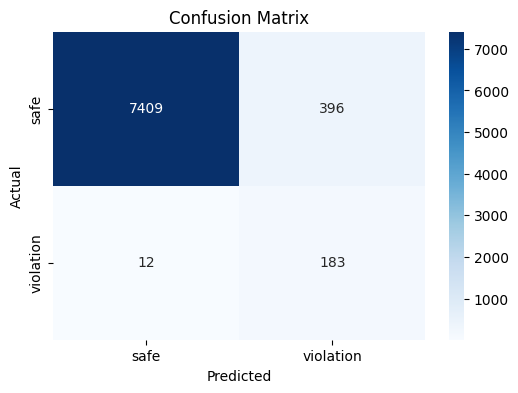

In [ ]:
# Harm Tweet Detection Evaluation Notebook
# 1: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from detoxify import Detoxify
from transformers import pipeline
from tqdm import tqdm

# 2: Project Introduction

    #  In this project, we aim to evaluate the performance of automatic toxic content detection tools Detoxify and HuggingFace's toxicity classifier against a human labeled dataset of tweets. The goal is to assess how accurately these models can identify harmful content and where they fall short, especially in terms of false positives and false negatives.

# 3: Dataset

from google.colab import drive
import pandas as pd


file_path = '/content/drive/MyDrive/Notebook Twitter Project/Raw-Data-Week-1,Jan-2025.csv'

df = pd.read_csv(file_path)

df.head()


# 4: Data cleaning

df = df.drop_duplicates(subset='text')
print(f"Dataset size after cleaning: {len(df)} tweets")


# 5: Load Model Prediction
  # Detoxify toxifcity classifier

!pip install detoxify
!pip install tqdm

from detoxify import Detoxify
detoxify_model = Detoxify('original')

from tqdm import tqdm
from detoxify import Detoxify
import pandas as pd

detoxify_model = Detoxify('original')


scores = []
for tweet in tqdm(df['tweet'], desc="Scoring tweets"):
    score = detoxify_model.predict(tweet)
    scores.append(score)

scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df], axis=1)

df.head()

toxicity_threshold = 0.8

df['ml_flagged'] = df['toxicity'] > toxicity_threshold

print(df['ml_flagged'].value_counts())

  # HuggingFace tosicity classifier

!pip install transformers datasets
!pip install torch

from transformers import pipeline

classifier = pipeline("text-classification", model="unitary/toxic-bert")

sample_text = "I hate you and hope bad things happen to you!"
result = classifier(sample_text)

print(result)

from transformers import pipeline
from tqdm import tqdm
import pandas as pd


classifier = pipeline("text-classification", model="unitary/toxic-bert")


toxic_labels = []
toxic_scores = []

for tweet in tqdm(df['tweet'], desc="Cross-checking with Toxic-BERT"):
    try:
        result = classifier(tweet[:512])[0]
        toxic_labels.append(result['label'])
        toxic_scores.append(result['score'])
    except Exception as e:
        toxic_labels.append("error")
        toxic_scores.append(0)

df['toxicbert_label'] = toxic_labels
df['toxicbert_score'] = toxic_scores

df.head()

  # Detection result exported for human review

import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f'/content/drive/MyDrive/Notebook Twitter Project/HumanReview{timestamp}.csv'

df.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")


  # Comparation result between Detoxify + HuggingFace model AND Human review

import pandas as pd

raw_path = '/content/drive/MyDrive/Notebook Twitter Project/RawData.csv'
review_path = '/content/drive/MyDrive/Notebook Twitter Project/HumanReview20250721_230147 - Clean Data.csv'

df_raw = pd.read_csv(raw_path)
df_review = pd.read_csv(review_path)

df_raw.columns = df_raw.columns.str.strip().str.lower()
df_review.columns = df_review.columns.str.strip().str.lower()

df = pd.merge(df_raw, df_review[['id', 'human review']], on='id', how='inner')


  # Quantitative Metrics (False Positive/Negative calculation)

df['transformer_harmful'] = df['transformer_harmful'].str.lower().str.strip()
df['human review'] = df['human review'].str.lower().str.strip()

df['transformer_harmful'] = df['transformer_harmful'].replace({
    'harmful': 'violation',
    'not harmful': 'safe'
})

df['match'] = df['transformer_harmful'] == df['human review']
df['false_positive'] = (df['human review'] == 'safe') & (df['transformer_harmful'] == 'violation')
df['false_negative'] = (df['human review'] == 'violation') & (df['transformer_harmful'] == 'safe')


  print("Evaluation Summary:")
  print(f"Total Samples: {len(df)}")
  print(f"Correct Matches: {df['match'].sum()}")
  print(f"False Positives (Model says Violation, human says Safe): {df['false_positive'].sum()}")
  print(f"False Negatives (Model says Safe, human says Violation): {df['false_negative'].sum()}")


output_path = '/content/drive/MyDrive/Notebook Twitter Project/Final_evaluation_result.csv'
df.to_csv(output_path, index=False)
print(f"\n Saved to: {output_path}")


print(df.columns.tolist())

  # Show false positives
false_positives = df[df['false_positive']]
display(false_positives[['tweet', 'transformer_harmful', 'human review']])

  # Show false negatives
false_negatives = df[df['false_negative']]
display(false_negatives[['tweet', 'transformer_harmful', 'human review']])


# 6: Confusion Matrix
  # to help understand how well the classification model performs visually
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_clean["human review"], df_clean["transformer_harmful"], labels=["safe", "violation"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["safe", "violation"], yticklabels=["safe", "violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Summary
  # Overall accuracy: 95%
  # Safe tweets: High precision and recall (F1-score 0.97)
  # Violation tweets: High recall (0.94) but low precision (0.32), leading to moderate F1-score (0.47)
  # The model detects most toxic tweets but often mislabels safe tweets as violations


